# **Git-Hub URL**


In [1]:
# https://github.com/aamemara/cnn-cancer-detection.git

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import rasterio
from tqdm import tqdm
import joblib

# **EDA**

In [3]:
drive_path = "/kaggle/input/"
output_dir = "/kaggle/working/"
print(os.listdir(drive_path+"histopathologic-cancer-detection"))
df_y_train_val = pd.read_csv(drive_path+"histopathologic-cancer-detection/train_labels.csv")
df_y_test = pd.read_csv(drive_path+"histopathologic-cancer-detection/sample_submission.csv")
print(df_y_train_val.info(),df_y_test.info())
print(df_y_train_val['label'].unique())

['sample_submission.csv', 'train_labels.csv', 'test', 'train']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
None None
[0 1]


In [4]:
# Create directories for image generator and save them to avoid creation in subsequent runs
train_path = drive_path+"histopathologic-cancer-detection/train"
test_path = drive_path+"histopathologic-cancer-detection/test"
# Get the list of image filenames
train_val_filenames_file =  output_dir+"train_val_filenames.txt"
test_filenames_file =  output_dir+"test_filenames.txt"
if os.path.exists(train_val_filenames_file) and os.path.exists(test_filenames_file):
    # Load the filenames from files
    with open(train_val_filenames_file, 'r') as f:
        X_train_val_filenames = [line.strip() for line in f.readlines()]
    with open(test_filenames_file, 'r') as f:
        X_test_filenames = [line.strip() for line in f.readlines()]
else:
    # Write directory contents to file
    with open(train_val_filenames_file, 'w') as f:
        X_train_val_filenames = os.listdir(train_path)
        for file in X_train_val_filenames:
            f.write("%s\n" % file)
    with open(test_filenames_file, 'w') as f:
        X_test_filenames = os.listdir(test_path)
        for file in X_test_filenames:
            f.write("%s\n" % file)
train_indices_file = output_dir+"train_indices.npy"
val_indices_file = output_dir+"val_indices.npy"
if os.path.exists(train_indices_file) and os.path.exists(val_indices_file):
    # Load the split indices from files
    train_indices = np.load(train_indices_file)
    val_indices = np.load(val_indices_file)
else:
    # Split the data and labels into training and validation sets
    train_indices, val_indices = train_test_split(
        np.arange(len(X_train_val_filenames)), test_size=0.1, shuffle=True, random_state=42)
    # Save the split indices to files
    np.save(train_indices_file, train_indices)
    np.save(val_indices_file, val_indices)

In [5]:
# Extract the filenames and labels corresponding to the split indices
X_train_filenames = [X_train_val_filenames[i] for i in train_indices]
X_val_filenames = [X_train_val_filenames[i] for i in val_indices]
# Create directories for training and validation data
train_dir = output_dir+"train_dir"
val_dir = output_dir+"val_dir"

train_size = 9000
num_pos = 0
num_neg = 0
if not os.path.exists(train_dir):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(train_dir+"/0", exist_ok=True)
    os.makedirs(train_dir+"/1", exist_ok=True)
    # Copy training images to the training directory
    for i in tqdm(range(len(X_train_filenames))):
        label = str(df_y_train_val.loc[df_y_train_val['id']+".tif"==X_train_filenames[i], 'label'].iloc[0])
        if num_pos == 0.5 * train_size and num_neg == 0.5 * train_size:
            break
        if label == str(1):
            if num_pos < 0.5 * train_size:
                num_pos += 1
            else:
                continue
        elif label == str(0):
            if num_neg < 0.5 * train_size:
                num_neg += 1
            else:
                continue
        src = os.path.join(train_path, X_train_filenames[i])
        dst = os.path.join(train_dir, label, X_train_filenames[i])
        shutil.copy(src, dst)

val_size = 1000
num_pos = 0
num_neg = 0
if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(val_dir+"/0", exist_ok=True)
    os.makedirs(val_dir+"/1", exist_ok=True)
    # Copy validation images to the validation directory
    for i in tqdm(range(len(X_val_filenames))):
        label = str(df_y_train_val.loc[df_y_train_val['id']+".tif"==X_val_filenames[i], 'label'].iloc[0])
        if num_pos == 0.5 * val_size and num_neg == 0.5 * val_size:
            break
        if label == str(1):
            if num_pos < 0.5 * val_size:
                num_pos += 1
            else:
                continue
        elif label == str(0):
            if num_neg < 0.5 * val_size:
                num_neg += 1
            else:
                continue
        src = os.path.join(train_path, X_val_filenames[i])
        dst = os.path.join(val_dir, label, X_val_filenames[i])
        shutil.copy(src, dst)

#image_shape = mpimg.imread(os.path.join(train_dir, str(y_train[0]), X_train_filenames[0])).shape
image_shape = (96, 96, 3)

  5%|▌         | 1186/22003 [01:05<19:13, 18.05it/s]


In [6]:
test_dir = output_dir+"test/test_dir"
if not os.path.exists(test_dir):
    os.makedirs(test_dir, exist_ok=True)
    # Copy test images to the test directory
    for i in tqdm(range(len(X_test_filenames))):
        src = os.path.join(test_path, X_test_filenames[i])
        dst = os.path.join(test_dir, X_test_filenames[i])
        shutil.copy(src, dst)

100%|██████████| 57458/57458 [06:35<00:00, 145.44it/s]


In [7]:
print(len(os.listdir(train_dir+"/0")),len(os.listdir(train_dir+"/1")),
      len(os.listdir(val_dir+"/0")),len(os.listdir(val_dir+"/1")))

4500 4500 500 500


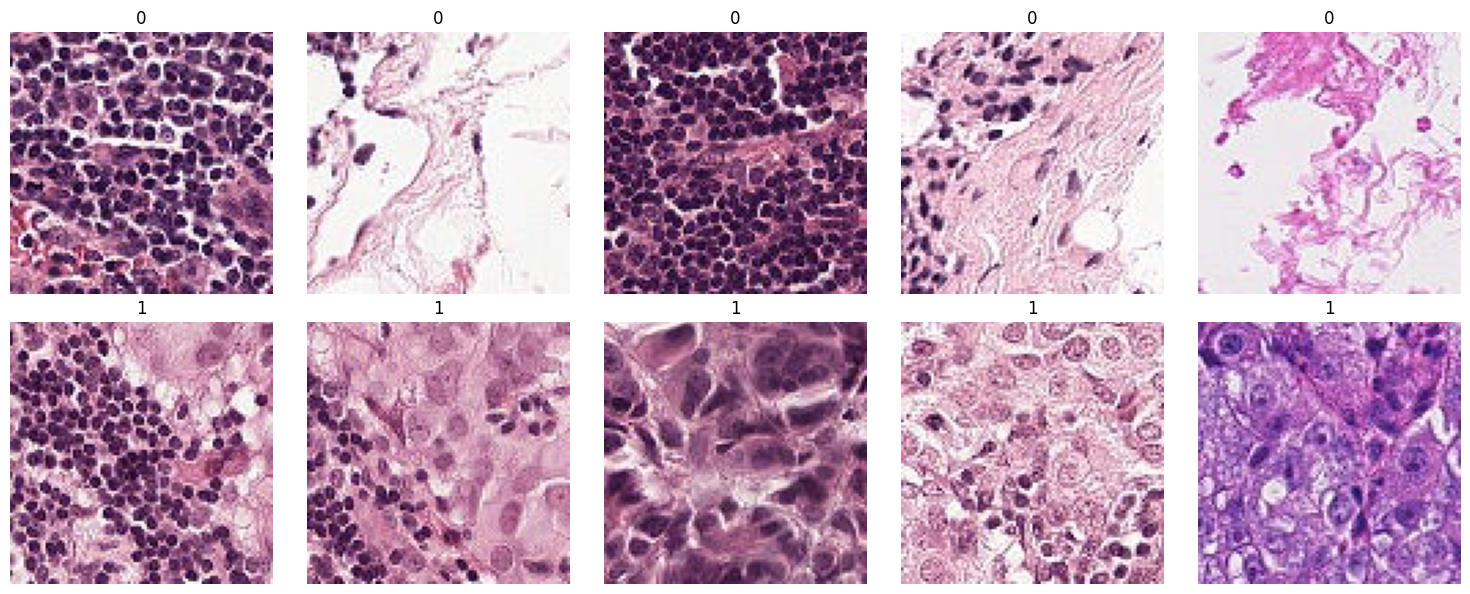

In [8]:
# Display first 10 train images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    if i < 5:
      # Display 5 negative training examples
      img = mpimg.imread(train_dir+"/0/"+os.listdir(train_dir+"/0")[i])
      axes[i].set_title("0")
    else:
      # Display 5 positive training examples
      img = mpimg.imread(train_dir+"/1/"+os.listdir(train_dir+"/1")[i-5])
      axes[i].set_title("1")
    axes[i].imshow(img)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# **Model building and training**

### **Data Load**

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_shape[0], image_shape[1]),
    batch_size=16,
    class_mode='binary')
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_shape[0], image_shape[1]),
    batch_size=16,
    class_mode='binary')

Found 9000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    output_dir+"test",
    target_size=(image_shape[0], image_shape[1]),
    batch_size=1,
    class_mode=None)

Found 57458 images belonging to 1 classes.


### **Sequential Model**

In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=image_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,873 (25.36 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
models_path = "/kaggle/input/model/tensorflow2/weights/1/"
if not os.path.exists(models_path+"model.weights.h5"):
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator)
    model.save_weights(output_dir+"model.weights.h5")
    with open("/kaggle/working/training_history.pkl", 'wb') as f:
        dill.dump(history.history, f)
    loaded_history = history.history
else:
    model.load_weights(models_path+"model.weights.h5")
    with open("/kaggle/input/history/training_history.pkl', 'rb') as f:
        loaded_history = dill.load(f)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


563/563 ━━━━━━━━━━━━━━━━━━━━ 120s 207ms/step - accuracy: 0.6639 - loss: 0.6328 - val_accuracy: 0.7740 - val_loss: 0.5137
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 106s 188ms/step - accuracy: 0.7642 - loss: 0.5136 - val_accuracy: 0.8000 - val_loss: 0.4442
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 142s 188ms/step - accuracy: 0.7662 - loss: 0.4949 - val_accuracy: 0.8030 - val_loss: 0.4377
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 108s 191ms/step - accuracy: 0.7862 - loss: 0.4696 - val_accuracy: 0.7520 - val_loss: 0.5414
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 142s 191ms/step - accuracy: 0.7855 - loss: 0.4635 - val_accuracy: 0.8250 - val_loss: 0.4099
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 112s 199ms/step - accuracy: 0.8079 - loss: 0.4326 - val_accuracy: 0.8130 - val_loss: 0.4121
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 133s 184ms/step - accuracy: 0.8230 - loss: 0.3976 - val_accuracy: 0.8270 - val_loss: 0.4206
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 103s 183ms/step - accuracy: 0.8322 - loss: 0.38

AttributeError: Can't pickle local object 'Layer._initialize_tracker.<locals>.<lambda>'

### **Results**

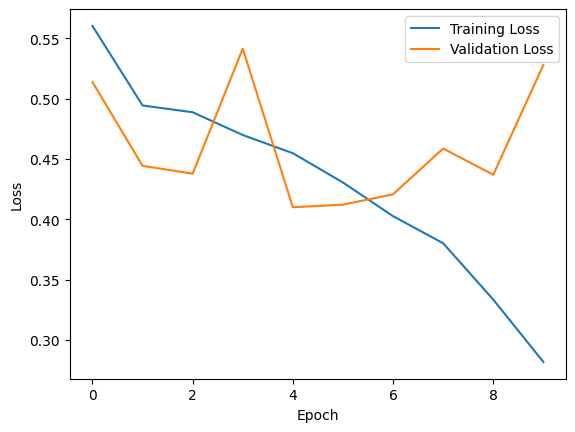

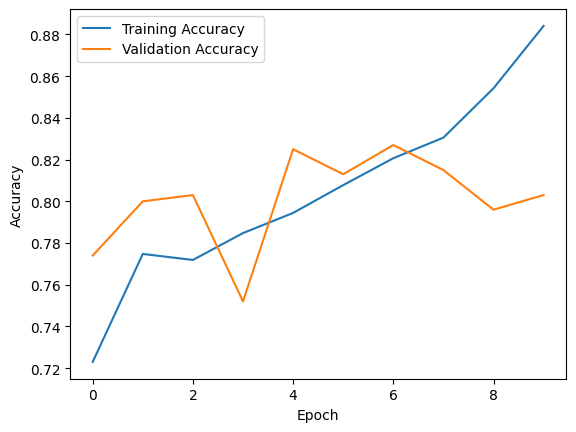

In [22]:
# Plot training and validation loss
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
# Plot training and validation accuracy
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
predictions = model.predict(test_generator, verbose=1)

    6/57458 ━━━━━━━━━━━━━━━━━━━━ 10:29 11ms/step   

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 594s 10ms/step


In [40]:
filenames = list(map(lambda x: x.replace("test_dir/", ""), test_generator.filenames))
filenames = list(map(lambda x: x.replace(".tif", ""), filenames))
df_y_test['id'] = filenames
df_y_test['label'] = (predictions > 0.5).astype(int)
df_y_test.to_csv(output_dir+"sample_submission.csv", index=False)

# **Conclusion**

The model has convolutional layers to apply filter that capture patterns across the image. Each deeper layer captures more complex patterns. Max pooling layers were used to reduce size and hence complexity in training the model. Flattening layer is used to flatten the model to be applied to dense layers. Dropout layer was used to prevent overfitting on training data.